# **Heart Disease Classification using Decision Tree & Random Forest**

Tuesday, 19 April 2022

***Created by Ahmad Nafiys Ismail***

# Classificaton with Python

> Notebook ini merupakan pelengkap materi pertemuan 22. Sangat dianjurkan untuk menggunakan notebook ini secara bersamaan dengan slides.

Outline:
* Part I
    * Load & Explore Data
        * Data Understanding
    * Data Analysis
        * Exploratory Data Analysis
        * Data Preparation
* Part II
    * Model Development
        * Data Preparation
        * Modelling
    * Model Evaluation
        * Confusion Matrix
        * Accuracy, Precision, Recall, F1-score

## 0. Libraries

Cell berikut berisikan semua _library_ yang akan kita gunakan.

> Urutan penulisan _library_ mengikuti konvensi [PEP8](https://peps.python.org/pep-0008/)

In [ ]:
import math
from collections import Counter, defaultdict
from functools import partial
from pprint import pprint

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.style.use("fivethirtyeight")

## 1. Data Loading & Exploration

Ada 2 dataset yang akan digunakan:
1. Dummy dataset, yaitu dataset yang berisi data kandidat yang diwawancarai yang berisikan informasi seperti level kandidat, bahasa pemrograman, dan lainnya, serta target variabel apakah kandidat tersebut diterima (`True`) atau tidak (`False`)
2. [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease)

### 1.1 Dummy Dataset

Di bawah ini adalah dataset dummy yang diambil dari buku Data Science from Scratch dari Joel Grus.

In [ ]:
# ref: Grus, J. Data Science From Scratch
dummy_data = [
    ({"level": "Senior", "lang": "Java", "tweets": "no", "phd": "no"}, False),
    ({"level": "Senior", "lang": "Java", "tweets": "no", "phd": "yes"}, False),
    ({"level": "Mid", "lang": "Python", "tweets": "no", "phd": "no"}, True),
    ({"level": "Junior", "lang": "Python", "tweets": "no", "phd": "no"}, True),
    ({"level": "Junior", "lang": "R", "tweets": "yes", "phd": "no"}, True),
    ({"level": "Junior", "lang": "R", "tweets": "yes", "phd": "yes"}, False),
    ({"level": "Mid", "lang": "R", "tweets": "yes", "phd": "yes"}, True),
    ({"level": "Senior", "lang": "Python", "tweets": "no", "phd": "no"}, False),
    ({"level": "Senior", "lang": "R", "tweets": "yes", "phd": "no"}, True),
    ({"level": "Junior", "lang": "Python", "tweets": "yes", "phd": "no"}, True),
    ({"level": "Senior", "lang": "Python", "tweets": "yes", "phd": "yes"}, True),
    ({"level": "Mid", "lang": "Python", "tweets": "no", "phd": "yes"}, True),
    ({"level": "Mid", "lang": "Java", "tweets": "yes", "phd": "no"}, True),
    ({"level": "Junior", "lang": "Python", "tweets": "no", "phd": "yes"}, False),
]

In [ ]:
print("Number of data:", len(dummy_data)) # len = panjang/count dari data 

Number of data: 14


#### 1.1.1 Sample Data

In [ ]:
sample = dummy_data[0] # data yg berbentuk list, set, tuple, dic harus menggunakan []

print("features:", sample[0]) # index angka pertama di python mulai dari 0
print("label:", sample[1])

features: {'level': 'Senior', 'lang': 'Java', 'tweets': 'no', 'phd': 'no'}
label: False


#### 1.1.2 Unique Values

In [ ]:
features = [pair[0] for pair in dummy_data]
levels = [feature["level"] for feature in features]
unique_levels = list(set(levels))

print("values in level:", levels)
print("unique values in level:", unique_levels)
print("number of unique values in level:", len(unique_levels))

values in level: ['Senior', 'Senior', 'Mid', 'Junior', 'Junior', 'Junior', 'Mid', 'Senior', 'Senior', 'Junior', 'Senior', 'Mid', 'Mid', 'Junior']
unique values in level: ['Mid', 'Junior', 'Senior']
number of unique values in level: 3


#### 1.1.3 Mode

In [ ]:
dict_level_count = {}

for value in levels:
    if value not in dict_level_count.keys():
        dict_level_count[value] = 1
    else:
        dict_level_count[value] += 1

# Alternative way to determine mode
# dict_level_count = {
#     value: sum([
#         1 for level in levels if level == value
#     ])
#     for value in unique_levels
# }

print("freq of each values:", dict_level_count)
print("most frequent values:",
      max(dict_level_count.items(), key=lambda items: items[-1]))

freq of each values: {'Senior': 5, 'Mid': 4, 'Junior': 5}
most frequent values: ('Senior', 5)


In [ ]:
dict_level_count = {}

for value in levels:
    if value not in dict_level_count.keys():
        dict_level_count[value] = 1
    else:
        dict_level_count[value] += 1

max_level_freq = max(dict_level_count.values())
modes = {
    level: mode
    for level, mode in dict_level_count.items()
    if mode == max_level_freq
}

print("freq of each values:", dict_level_count)
print("mode:", modes)

freq of each values: {'Senior': 5, 'Mid': 4, 'Junior': 5}
mode: {'Senior': 5, 'Junior': 5}


### 1.2 Personal Key Indicators for Health Disease

Dataset ini merupakan data survei CDC tahun 2020 dari 400k orang dewasa yang berkaitan dengan kondisi kesehatan mereka. Dengan menggunakan dataset ini, kita akan membuat sebuah model untuk mengklasifikasikan apakah seseorang dengan kondisi kesehatan tertentu memiliki sakit jantung atau tidak yang direpresentasikan oleh fitur `HeartDisease`.

Dataset ini dapat diambil dari [Kaggle](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease).

In [ ]:
df_heart = pd.read_csv("/content/heart_2020_cleaned.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# mengecek & memanggil data yg baru diupload
df_heart

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26377,No,30.04,No,No,No,0.0,15.0,No,Female,25-29,American Indian/Alaskan Native,No,Yes,Very good,4.0,No,No,No
26378,No,27.20,No,No,No,0.0,5.0,No,Male,25-29,White,No,Yes,Excellent,8.0,No,No,No
26379,No,25.66,Yes,No,No,0.0,0.0,No,Male,30-34,White,No,Yes,Excellent,6.0,No,No,No
26380,No,26.63,Yes,No,No,0.0,10.0,No,Female,55-59,White,No,Yes,Very good,6.0,No,No,No


In [ ]:
# memanggil data dari paling atas (default : 5 data)
df_heart.head(20)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
5,Yes,28.87,Yes,No,No,6.0,0.0,Yes,Female,75-79,Black,No,No,Fair,12.0,No,No,No
6,No,21.63,No,No,No,15.0,0.0,No,Female,70-74,White,No,Yes,Fair,4.0,Yes,No,Yes
7,No,31.64,Yes,No,No,5.0,0.0,Yes,Female,80 or older,White,Yes,No,Good,9.0,Yes,No,No
8,No,26.45,No,No,No,0.0,0.0,No,Female,80 or older,White,"No, borderline diabetes",No,Fair,5.0,No,Yes,No
9,No,40.69,No,No,No,0.0,0.0,Yes,Male,65-69,White,No,Yes,Good,10.0,No,No,No


In [ ]:
# memanggil data dari paling bawah (default : 5 data)
df_heart.tail(15)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
26367,Yes,35.78,No,No,No,0.0,0.0,Yes,Male,65-69,Hispanic,No,No,Good,6.0,No,No,No
26368,No,25.80,No,No,No,2.0,0.0,No,Male,65-69,White,Yes,Yes,Very good,9.0,No,No,Yes
26369,No,29.76,No,No,No,0.0,0.0,No,Female,65-69,White,No,Yes,Very good,5.0,No,No,No
26370,No,25.39,Yes,No,No,0.0,15.0,No,Female,30-34,Hispanic,No,Yes,Excellent,7.0,No,No,No
26371,No,30.30,No,No,No,0.0,0.0,No,Female,45-49,Asian,No,Yes,Excellent,8.0,No,No,No
26372,No,30.41,Yes,No,No,0.0,0.0,No,Male,60-64,White,"No, borderline diabetes",Yes,Fair,5.0,No,No,No
26373,No,21.83,No,No,No,0.0,15.0,No,Male,45-49,White,No,Yes,Very good,7.0,No,No,No
26374,No,28.37,No,No,No,0.0,0.0,No,Male,60-64,White,No,Yes,Excellent,9.0,No,No,No
26375,No,40.69,Yes,No,No,14.0,0.0,Yes,Male,60-64,White,Yes,Yes,Good,9.0,Yes,No,No
26376,No,23.63,No,No,No,0.0,5.0,No,Female,18-24,Hispanic,No,Yes,Good,8.0,No,No,No


In [ ]:
# melihat info tabel secara ringkas
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26382 entries, 0 to 26381
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      26382 non-null  object 
 1   BMI               26382 non-null  float64
 2   Smoking           26382 non-null  object 
 3   AlcoholDrinking   26382 non-null  object 
 4   Stroke            26382 non-null  object 
 5   PhysicalHealth    26382 non-null  float64
 6   MentalHealth      26382 non-null  float64
 7   DiffWalking       26382 non-null  object 
 8   Sex               26382 non-null  object 
 9   AgeCategory       26382 non-null  object 
 10  Race              26382 non-null  object 
 11  Diabetic          26382 non-null  object 
 12  PhysicalActivity  26382 non-null  object 
 13  GenHealth         26382 non-null  object 
 14  SleepTime         26382 non-null  float64
 15  Asthma            26382 non-null  object 
 16  KidneyDisease     26382 non-null  object

In [ ]:
# melihat ukuran dari tabel (baris, kolom)
df_heart.shape

(26382, 18)

## 2. Exploratory Data Analysis


**Data Dictionary**:

| column | description |
| ------ | ----------- |
| `HeartDisease` | Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI) |
| `BMI` | Body Mass Index (BMI) |
| `Smoking` | Have you smoked at least 100 cigarettes in your entire life? *(Note: 5 packs = 100 cigarettes)* |
| `AlcoholDrinking` | Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week |
| `Stroke` | (Ever told) (you had) a stroke? |
| `PhysicalHealth` | Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 |
| `MentalHealth` | Thinking about your mental health, for how many days during the past 30 days was your mental health not good? |
| `DiffWalking` | Do you have serious difficulty walking or climbing stairs? |
| `Sex` | Are you male of female |
| `AgeCategory` | Fourteen-level age category |
| `Race` | Imputed race/ethnicity value |
| `Diabetic` | (Ever told) (you had) diabetes? |
| `PhysicalActivity` | Adults who reported doing physical activity or exercise during the past 30 days other than their regular job |
| `GenHealth` | Would you say that in general your health is... |
| `SleepTime` | On average, how many hours of sleep do you get in a 24-hour period? |
| `Asthma` | (Ever told) (you had) asthma? |
| `KidneyDisease` | Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease? |
| `SkinCancer` | (Ever told) (you had) skin cancer? |

In [ ]:
# menampilkan summary statistics
df_heart.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [ ]:
numerical_features = df_heart.select_dtypes(include="number").columns.tolist() # memisahkan kolom numerik
categorical_features = df_heart.select_dtypes(include="object").columns.tolist() # memishakan kolom kategorik

print("Numerical features:")
pprint(numerical_features) # print untuk tipe data yang lebih kompleks (list, tuple, set, dll)
print("Categorical features:")
pprint(categorical_features, compact=True) # agar memastikan categorical_features tidak berubah ketika  dipanggil lagi

Numerical features:
['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
Categorical features:
['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',
 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma',
 'KidneyDisease', 'SkinCancer']


### 2.1 Summary Statistic

In [ ]:
# menampilkan summ stastictics utk data variabel Kategorik
df_heart[categorical_features].describe()

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
count,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795
unique,2,2,2,2,2,2,13,6,4,2,5,2,2,2
top,No,No,No,No,No,Female,65-69,White,No,Yes,Very good,No,No,No
freq,292422,187887,298018,307726,275385,167805,34151,245212,269653,247957,113858,276923,308016,289976


In [ ]:
# menampilkan summ stastictics utk data variabel Numerik
df_heart[numerical_features].describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,26382.000000,26382.000000,26382.000000,26382.000000
mean,28.182574,3.782238,3.947123,7.136874
std,6.349593,8.358024,7.946838,1.499008
min,12.400000,0.000000,0.000000,1.000000
25%,23.750000,0.000000,0.000000,6.000000
50%,27.250000,0.000000,0.000000,7.000000
75%,31.320000,2.000000,4.000000,8.000000
max,83.000000,30.000000,30.000000,24.000000


In [ ]:
#  huruf T untuk transform/transpose dataframe
df_heart[numerical_features].describe().T 

,count,mean,std,min,25%,50%,75%,max
BMI,26382.0,28.182574,6.349593,12.4,23.75,27.25,31.32,83.0
PhysicalHealth,26382.0,3.782238,8.358024,0.0,0.00,0.00,2.00,30.0
MentalHealth,26382.0,3.947123,7.946838,0.0,0.00,0.00,4.00,30.0
SleepTime,26382.0,7.136874,1.499008,1.0,6.00,7.00,8.00,24.0


Dari summary di atas:
* Median dari `PhysicalHealth` dan `MentalHealth` lebih kecil daripada rata-rata nya, sehingga kemungkinan distribusinya left-skewed
* Kebanyakan nilai `PhysicalHealth` dan `MentalHealth` antara 0 sampai 3 (dari Q1 sampai Q3), sehingga kemungkinan terdapat banyak pencilan
* Ada baris yang nilai `SleepTime` nya 24 jam, apakah ini berarti ia tidur selama seharian?


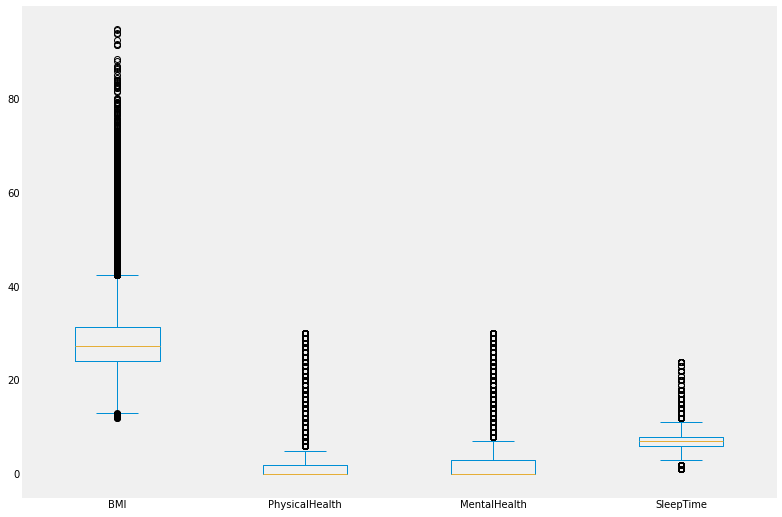

In [ ]:
df_heart[numerical_features].plot(kind="box", figsize=(12, 9))
plt.grid(False)
plt.show()

Dari visualisasi box plot di atas:
* Semua distribusi `BMI`, `PhysicalHealth`, `MentalHealth`, `SleepTime` terlihat right-skewed
* Meski begitu, nilai rata-rata dan median `BMI` dan `SleepTime` cenderung sama

Selain menggnakan boxplot seperti di atas, kita juga bisa menggunakan violin plot seperti di bawah ini untuk mengetahui bentuk kurva distribusi masing-masing fitur dengan lebih jelas

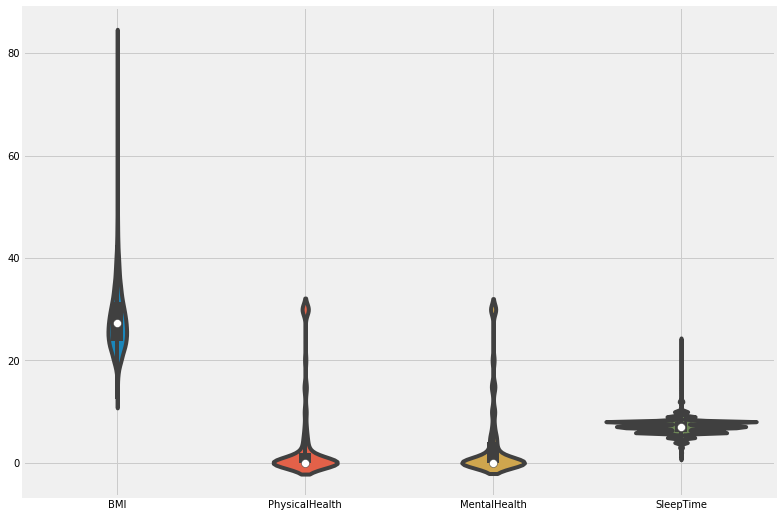

In [ ]:
# Membuat grafik violinplot
plt.figure(figsize=(12, 9)) # figsize (ukuran grafik (x , y))
sns.violinplot(data=df_heart[numerical_features])
plt.grid(True)
plt.show()

In [ ]:
df_heart[categorical_features].describe().T

,count,unique,top,freq
HeartDisease,26382,2,No,23943
Smoking,26382,2,No,15296
AlcoholDrinking,26382,2,No,24646
Stroke,26382,2,No,25298
DiffWalking,26382,2,No,22303
Sex,26382,2,Female,14078
AgeCategory,26382,13,65-69,2937
Race,26382,6,White,18680
Diabetic,26382,4,No,22082
PhysicalActivity,26382,2,Yes,20189


### 2.2 Correlation

Corelation = Untuk Multi-variate Analysis

In [ ]:
df_heart.corr()

,BMI,PhysicalHealth,MentalHealth,SleepTime
BMI,1.000000,0.109788,0.064131,-0.051822
PhysicalHealth,0.109788,1.000000,0.287987,-0.061387
MentalHealth,0.064131,0.287987,1.000000,-0.119717
SleepTime,-0.051822,-0.061387,-0.119717,1.000000


In [ ]:
df_heart.corr()['BMI'].sort_values().to_frame()

,BMI
SleepTime,-0.051822
MentalHealth,0.064131
PhysicalHealth,0.109788
BMI,1.000000


In [ ]:
df_heart.corr()['HeartDisease'].sort_values().to_frame()

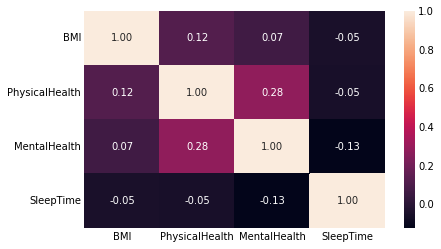

In [ ]:
# Grafik Heatmap 1
sns.heatmap(df_heart.corr(), annot=True, fmt=".2f")
plt.show()

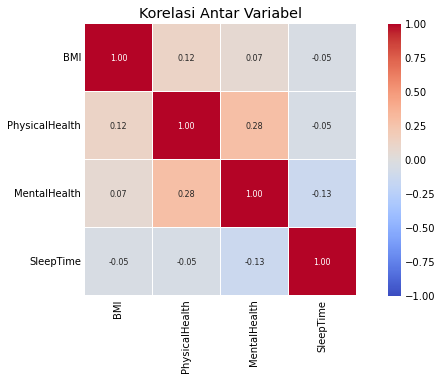

In [ ]:
# Grafik Heatmap 2
corr = df_heart.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, vmin=-1, vmax=1, cmap = "coolwarm", annot=True, annot_kws={"size":8}, fmt='.2f', linewidths=0.1, square = True)
plt.title("Korelasi Antar Variabel")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


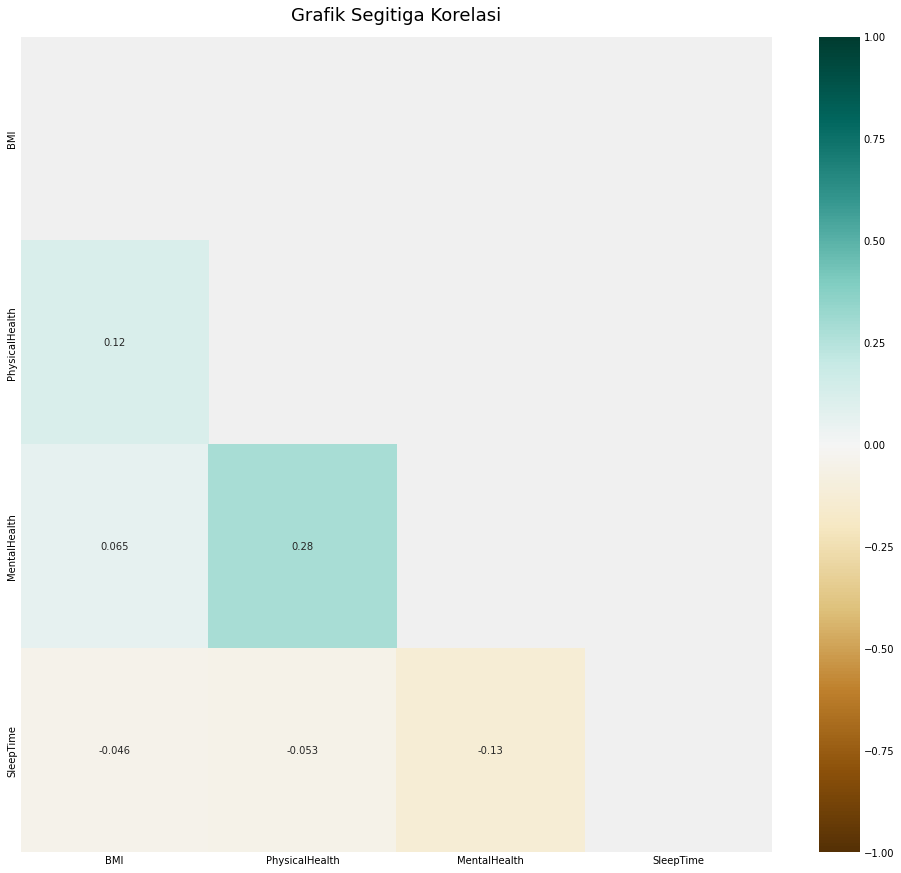

In [ ]:
# Grafik Heatmap 3
plt.figure(figsize=(15, 15))
mask = np.triu(np.ones_like(df_heart.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_heart.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Grafik Segitiga Korelasi', fontdict={'fontsize':18}, pad=16);


### 2.3 EDA on Categorical Features

In [ ]:
df_heart[categorical_features].head(20)

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,No,Yes,No,No,No,Female,55-59,White,Yes,Yes,Very good,Yes,No,Yes
1,No,No,No,Yes,No,Female,80 or older,White,No,Yes,Very good,No,No,No
2,No,Yes,No,No,No,Male,65-69,White,Yes,Yes,Fair,Yes,No,No
3,No,No,No,No,No,Female,75-79,White,No,No,Good,No,No,Yes
4,No,No,No,No,Yes,Female,40-44,White,No,Yes,Very good,No,No,No
5,Yes,Yes,No,No,Yes,Female,75-79,Black,No,No,Fair,No,No,No
6,No,No,No,No,No,Female,70-74,White,No,Yes,Fair,Yes,No,Yes
7,No,Yes,No,No,Yes,Female,80 or older,White,Yes,No,Good,Yes,No,No
8,No,No,No,No,No,Female,80 or older,White,"No, borderline diabetes",No,Fair,No,Yes,No
9,No,No,No,No,Yes,Male,65-69,White,No,Yes,Good,No,No,No


In [ ]:
df_heart['HeartDisease'].head(20)

0      No
1      No
2      No
3      No
4      No
5     Yes
6      No
7      No
8      No
9      No
10    Yes
11     No
12     No
13     No
14     No
15     No
16     No
17     No
18     No
19     No
Name: HeartDisease, dtype: object

### 2.4 Number of Unique Values

In [ ]:
df_heart[categorical_features].nunique()

HeartDisease         2
Smoking              2
AlcoholDrinking      2
Stroke               2
DiffWalking          2
Sex                  2
AgeCategory         13
Race                 6
Diabetic             4
PhysicalActivity     2
GenHealth            5
Asthma               2
KidneyDisease        3
SkinCancer           2
dtype: int64

### 2.5 Count of Unique Values

In [ ]:
# menghitung/counting jumlah persebaran setiap Unique Value didalam setiap variabel
for feature in categorical_features:
    print(df_heart[feature].value_counts())

No     23943
Yes     2439
Name: HeartDisease, dtype: int64
No     15296
Yes    11086
Name: Smoking, dtype: int64
No     24646
Yes     1736
Name: AlcoholDrinking, dtype: int64
No     25298
Yes     1084
Name: Stroke, dtype: int64
No     22303
Yes     4079
Name: DiffWalking, dtype: int64
Female    14078
Male      12304
Name: Sex, dtype: int64
65-69          2937
70-74          2734
60-64          2734
55-59          2250
80 or older    2208
75-79          2036
50-54          1980
45-49          1765
35-39          1610
18-24          1598
40-44          1567
30-34          1555
25-29          1408
Name: AgeCategory, dtype: int64
White                             18680
Hispanic                           3069
Black                              2053
American Indian/Alaskan Native     1007
Other                               923
Asian                               650
Name: Race, dtype: int64
No                         22082
Yes                         3466
No, borderline diabetes      648
Ye

### 2.5 Visualization

#### 2.5.1 Age Category

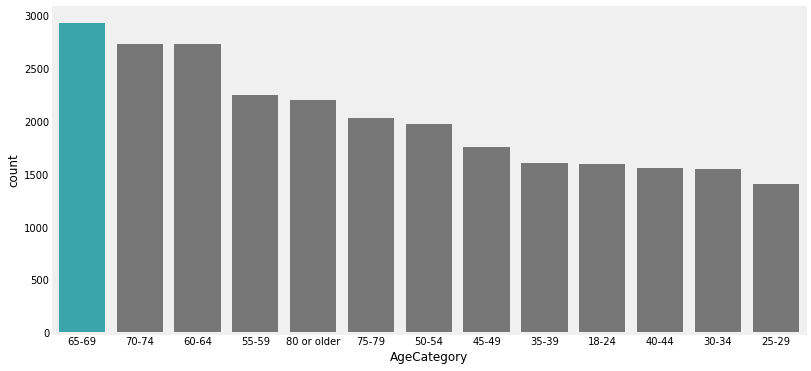

In [ ]:
age_category_order = df_heart.AgeCategory.value_counts().index

plt.figure(figsize=(12, 6))
sns.countplot(
    x="AgeCategory",
    data=df_heart,
    order=age_category_order,
    palette=["#29B5BF"] + (len(age_category_order)-1)*["#777777"]
)
plt.grid(False)
plt.show()

Dari visualisasi di atas, terlihat bahwa kategori umum **65-69** paling banyak dijumpai.

Untuk kemudahan visualisasi fitur yang lain, kita akan menggunakan fungsi berikut.

In [ ]:
# melihat persebaran Heart Diseases dengan umur
plt.figure(figsize=(12, 6))
sns.countplot(
    x="AgeCategory",
    data=df_heart,
    hue="HeartDisease",
    order=sorted(df_heart.AgeCategory.unique()),
    palette=["#29B5BF"] + ["#777777"]
)
plt.grid(False)
plt.show()

In [ ]:
# fungsi def plot_count, kita gak perlu tulis code yg sama seperti sebelumnya
def plot_count(x, data=df_heart, palette=None, figsize=(12, 6)):
    column_order = data[x].value_counts().index

    plt.figure(figsize=figsize)
    sns.countplot(
        x=x, data=data, order=column_order,
        palette=palette
    )
    plt.grid(False)
    plt.show()

#### 2.5.2 Race

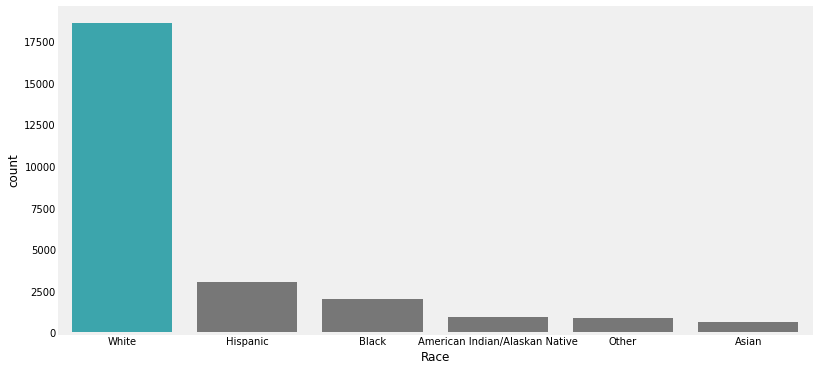

In [ ]:
race_order = df_heart["Race"].value_counts().index
plot_count("Race", palette=["#29B5BF"] + (len(race_order)-1)*["#777777"]) # fungsi grafik dari yg sebelumnya

Terlihat bahwa dari 6 suku yang ada, `White` menjadi yang paling banyak. Sedangkan untuk `Asian` berada pada urutan 2 terakhir.

Mungkin kita bertanya, apakah ada pola pada fitur Race jika kita bandingkan dengan responden dengan atau tidak dengan penyakit jantung?

In [ ]:
plot_count(
    "Race", palette=["#29B5BF"] + (len(race_order)-1)*["#777777"],
    hue="HeartDisease"
)

#### 2.5.3 General Health

In [ ]:
gen_health_order = df_heart["GenHealth"].value_counts().index
plot_count(
    "GenHealth",
    palette=["#29B5BF"] + (len(gen_health_order)-1)*["#777777"]
)

NameError: ignored

Dari visualisasi di atas, bisa disimpulkan bahwa kebanyakan responden sangat percaya bahwa kondisi kesehatan mereka secara umum sangat baik.

In [ ]:
plot_count(
    x="GenHealth", palette=["#29B5BF"] + (len(gen_health_order)-1)*["#777777"],
    hue="HeartDisease"
)

#### 2.5.4 Sex

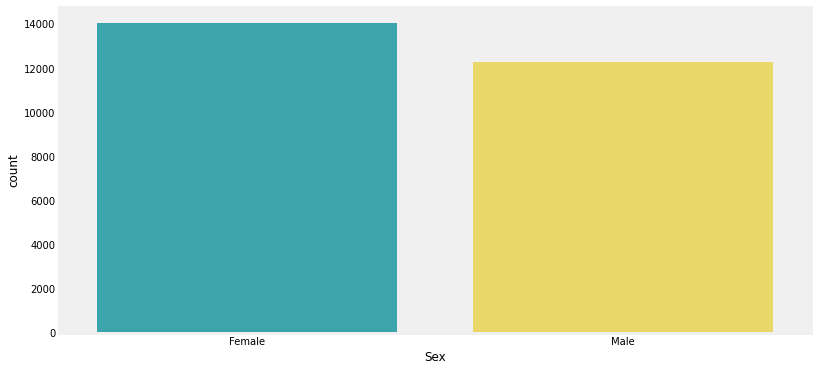

In [ ]:
sex_order = df_heart["Sex"].value_counts().index
plot_count(
    "Sex",
    palette=["#29B5BF", "#FFE653"]
)

Antara laki-laki dan perempuan, proporsi responden hampir berimbang. Meskipun, persentase perempuan sedikit lebih banyak dibandingkan laki-laki.

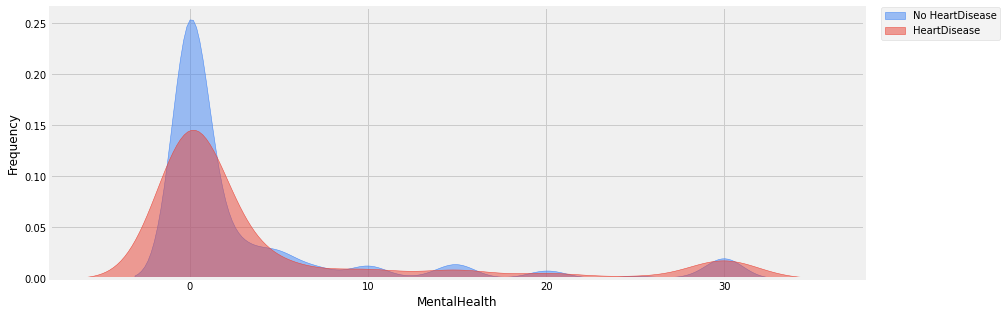

In [ ]:
fig, ax = plt.subplots(figsize = (13,5))
sns.kdeplot(df_heart[df_heart["HeartDisease"]=='No']["MentalHealth"], alpha=0.5,shade = True, color="#4285f4", label="No HeartDisease", ax = ax)
sns.kdeplot(df_heart[df_heart["HeartDisease"]=='Yes']["MentalHealth"], alpha=0.5,shade = True, color="#ea4335", label="HeartDisease", ax = ax)
ax.set_xlabel("MentalHealth")
ax.set_ylabel("Frequency")
ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

# [Meeting 22] Classification with Python - Part 2


## 3. Model Development

Pada bagian ini, kita akan mencoba untuk membuat model **Decision Tree** kita sendiri tanpa bantuan `scikit-learn` menggunakan data dummy sebelumnya.

# 3.1 Modelling w/ Decision Tree

### 3.1.1 Dummy Dataset

In [ ]:
def entropy(class_probabilites):
    "Calculate the entropy of the given list of class probabilites"
    return sum(
        -p * np.log2(p)
        for p in class_probabilites if p
    )


def class_probabilities(labels):
    "Calculate given class/target variable probabilites"
    total_count = len(labels)
    return [
        count / total_count
        for count in Counter(labels).values()
    ]


def data_entropy(labeled_data):
    "Calculate entropy of a feature with a corresponding labels"
    labels = [label for _, label in labeled_data]
    probabilities = class_probabilities(labels)
    return entropy(probabilities)


def partition_entropy(subsets):
    """Calculate entropy from partition of data into subsets.

    Subsets is a list of lists of labeled data.
    """
    total_count = sum(len(subset) for subset in subsets)
    return sum(
        data_entropy(subset) * len(subset) / total_count
        for subset in subsets
    )


def partition_by(inputs, attribute):
    """each input is a pair (attribute_dict, label).
    
    Returns a dict : feature_value -> inputs
    """
    groups = defaultdict(list)
    for input in inputs:
        key = input[0][attribute] # get the value of the specified attribute
        groups[key].append(input) # then add this input to the correct list
    return groups


def partition_entropy_by(inputs, attribute):
    """computes the entropy corresponding to the given partition"""
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())


#### 3.1.1 Information Gain for Whole Dataset

In [ ]:
label_entropy = data_entropy(dummy_data)
print("label entropy:", label_entropy)

print("entropy:")
for feature in ["level", "lang", "tweets", "phd"]:
    print(feature, ":", partition_entropy_by(dummy_data, feature))

label entropy: 0.9402859586706309
entropy:
level : 0.6935361388961919
lang : 0.8601317128547441
tweets : 0.7884504573082896
phd : 0.8921589282623617


Karena variable feature `level` punya nilai entropi terrendah, maka dijadikan menjadi root node pada decision tree

In [ ]:
split_by_level = pd.DataFrame(
    [
     (value, labels)
     for features, labels in dummy_data
     for feat, value in features.items()
     if feat == "level"
    ],
    columns=["level", "label"]
)
split_by_level.groupby("level").agg({"label": list})

,label
level,
Junior,"[True, True, False, True, False]"
Mid,"[True, True, True, True]"
Senior,"[False, False, False, True, True]"


#### 3.1.2 Information Gain after Split by `level='Senior'`

In [ ]:
senior_inputs = [
    (input, label)
    for input, label in dummy_data
    if input["level"] == "Senior"
]
print("split by senior value:")
pprint(senior_inputs)

for feature in ['lang', 'tweets', 'phd']:
    print(feature, partition_entropy_by(senior_inputs, feature))

split by senior value:
[({'lang': 'Java', 'level': 'Senior', 'phd': 'no', 'tweets': 'no'}, False),
 ({'lang': 'Java', 'level': 'Senior', 'phd': 'yes', 'tweets': 'no'}, False),
 ({'lang': 'Python', 'level': 'Senior', 'phd': 'no', 'tweets': 'no'}, False),
 ({'lang': 'R', 'level': 'Senior', 'phd': 'no', 'tweets': 'yes'}, True),
 ({'lang': 'Python', 'level': 'Senior', 'phd': 'yes', 'tweets': 'yes'}, True)]
lang 0.4
tweets 0.0
phd 0.9509775004326938


In [ ]:
split_by_tweets = pd.DataFrame(
    [
     (value, labels)
     for features, labels in dummy_data
     for feat, value in features.items()
     if feat == "tweets"
    ],
    columns=["tweets", "label"]
)
split_by_tweets.groupby("tweets").agg({"label": list})

,label
tweets,
no,"[False, False, True, True, False, True, False]"
yes,"[True, False, True, True, True, True, True]"


#### 3.1.3 Information Gain after Split by `level='Junior'`

In [ ]:
junior_inputs = [
    (input, label)
    for input, label in dummy_data
    if input["level"] == "Junior"
]
print("split by junior level:")
pprint(junior_inputs)

for feature in ['lang', 'tweets', 'phd']:
    print(feature, partition_entropy_by(junior_inputs, feature))

split by junior level:
[({'lang': 'Python', 'level': 'Junior', 'phd': 'no', 'tweets': 'no'}, True),
 ({'lang': 'R', 'level': 'Junior', 'phd': 'no', 'tweets': 'yes'}, True),
 ({'lang': 'R', 'level': 'Junior', 'phd': 'yes', 'tweets': 'yes'}, False),
 ({'lang': 'Python', 'level': 'Junior', 'phd': 'no', 'tweets': 'yes'}, True),
 ({'lang': 'Python', 'level': 'Junior', 'phd': 'yes', 'tweets': 'no'}, False)]
lang 0.9509775004326938
tweets 0.9509775004326938
phd 0.0


In [ ]:
split_by_phd = pd.DataFrame(
    [
     (value, labels)
     for features, labels in dummy_data
     for feat, value in features.items()
     if feat == "phd"
    ],
    columns=["phd", "label"]
)
split_by_phd.groupby("phd").agg({"label": list})

,label
phd,
no,"[False, True, True, True, False, True, True, T..."
yes,"[False, False, True, True, True, False]"


#### 3.1.4 Putting It All Together

Setelah mencoba menghitung secara manual satu per satu fitur-fitur pada data dummy, kita akan membuat model Decision Tree yang akan menghitung nilai entropy seperti di atas untuk setiap fitur secara otomatis menggunakan fungsi berikut.

In [ ]:
def build_tree(inputs, split_candidates=None):
    # if this is our first pass,
    # all keys of the first input are split candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()

    # count Trues and Falses in the inputs
    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label])
    num_falses = num_inputs - num_trues

    # no True(s)? return "False" leaf
    if num_trues == 0:
        return False
    # no False(s)? return "True" leaf
    if num_falses == 0:
        return True
    # if no split candidates left,
    # return the majority leaf
    if not split_candidates:
        return num_trues >= num_falses

    # otherwise, split on the best attribute
    best_attribute = min(
        split_candidates,
        key=partial(partition_entropy_by, inputs)
    )
    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates if a != best_attribute]

    # recursively build the subtrees
    subtrees = {
        attribute_value: build_tree(subset, new_candidates)
        for attribute_value, subset in partitions.items()
    }
    subtrees[None] = num_trues > num_falses # default case
    return (best_attribute, subtrees)


def classify(tree, input):
    """classify the input using the given decision tree"""
    # if this is a leaf node, return its value
    if tree in [True, False]:
        return tree

    # otherwise this tree consists of an attribute to split on
    # and a dictionary whose keys are values of that attribute
    # and whose values of are subtrees to consider next
    attribute, subtree_dict = tree

    # None if input is missing attribute
    subtree_key = input.get(attribute)
    # if no subtree for key, we'll use the None subtree
    if subtree_key not in subtree_dict:
        subtree_key = None
    # choose the appropriate subtree, and use it to classify the input
    subtree = subtree_dict[subtree_key]
    return classify(subtree, input)

In [ ]:
tree = build_tree(dummy_data)
tree

('level',
 {'Junior': ('phd', {None: True, 'no': True, 'yes': False}),
  'Mid': True,
  None: True,
  'Senior': ('tweets', {None: False, 'no': False, 'yes': True})})

Dari Decision Tree yang sudah dibentuk di atas (dalam bentuk tuple atas fitur dan sub-pohon):
* fitur `level` menjadi root node
* untuk setiap kemungkinan nilai fitur `level`, terdapat sub-pohon (dalam dict) yang juga berisi **decision node** selanjutnya

Setelah itu, kita bisa gunakan model tersebut untuk coba membuat prediksi berdasarkan input yang diberikan.

In [ ]:
for test, target in dummy_data:
    print(classify(tree, test), f"({target})")

False (False)
False (False)
True (True)
True (True)
True (True)
False (False)
True (True)
False (False)
True (True)
True (True)
True (True)
True (True)
True (True)
False (False)


In [ ]:
sample = {
    "level": "Junior",
    "lang": "Python",
}
classify(tree, sample)

True

In [ ]:
sample = {
    "level": "Senior",
    "lang": "Java",
}
classify(tree, sample)

False

### 3.2 Personal Key Indicators for Health Disease

Mari kita lihat sekali lagi 5 baris pertama dari dataset heart disease.

In [ ]:
df_heart = pd.read_csv('/content/heart_2020_cleaned.csv')

In [ ]:
df_heart

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [ ]:
df_heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


Untuk memudahkan proses training, kita akan buat variabel `X` yang berisi semua fitur-fitur untuk melatih model dan variabel `y` yang berisi target variabel.

In [ ]:
X = df_heart.drop(columns=["HeartDisease"]).copy()
y = df_heart["HeartDisease"].copy()

#### 3.2.1 Data Splitting

Seperti dijelaskan dalam slide, kita akan bagi dataset menjadi **training**, **dev validation**, dan **test** set dengan proporsi **99:0.5:0.5**.

In [ ]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=.1, stratify=y, random_state=11)
X_dev, X_test, y_dev, y_test = train_test_split(X_rest, y_rest, test_size=.5, stratify=y_rest, random_state=11)

print("training size:", X_train.shape[0])
print("dev size:", X_dev.shape[0])
print("test size:", X_test.shape[0])

training size: 287815
dev size: 15990
test size: 15990


> Proporsi pembagian dataset sedikit berbeda dari biasanya (70:20:10 / 80:10:10 / dst.) dikarenakan ukuran dataset yang sangat besar, sehingga jumlah development dan test data sudah cukup dengan proporsi yang kecil (**0.5%**)

Diperoleh:
* data training sebanyak **287,815** baris
* data development sebanyak **15,990** baris
* data test sebanyak **15,990** baris

#### 3.2.2 Categorical Encoding

Fitur **kategorik nominal**, yaitu `Race` dan `Sex` akan diubah menjadi matriks one-hot encoding, sedangkan fitur **kategorik ordinal** (sisa fitur kategorik lainnya) akan diubah ke dalam bentuk angka terurut.

In [ ]:
nominal_features = ["Race", "Sex"]
ordinal_features = X.select_dtypes(
    include="object"
).drop(columns=nominal_features).columns.tolist()

print("nominal features:", nominal_features)
print("ordinal features:")
pprint(ordinal_features, compact=True)

NameError: ignored

In [ ]:
# Fungsi OHE untuk Categorical Encoding
onehot = OneHotEncoder()
onehot.fit(X_train[nominal_features])
X_train_onehot = pd.DataFrame(
    onehot.transform(X_train[nominal_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
X_dev_onehot = pd.DataFrame(
    onehot.transform(X_dev[nominal_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
X_test_onehot = pd.DataFrame(
    onehot.transform(X_test[nominal_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
print("one-hot matrix:")
display(X_train_onehot)

ordinal = OrdinalEncoder()
ordinal.fit(X_train[ordinal_features])
X_train_ordinal = pd.DataFrame(
    ordinal.transform(X_train[ordinal_features]),
    columns=ordinal.feature_names_in_
)
X_dev_ordinal = pd.DataFrame(
    ordinal.transform(X_dev[ordinal_features]),
    columns=ordinal.feature_names_in_
)
X_test_ordinal = pd.DataFrame(
    ordinal.transform(X_test[ordinal_features]),
    columns=ordinal.feature_names_in_
)
print("ordinal matrix:")
display(X_train_ordinal)

one-hot matrix:


,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,Sex_Female,Sex_Male
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...
287810,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
287811,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
287812,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
287813,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


ordinal matrix:


,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,9.0,0.0,1.0,2.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,12.0,0.0,1.0,4.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
287810,1.0,1.0,0.0,0.0,2.0,0.0,1.0,4.0,1.0,0.0,0.0
287811,0.0,0.0,0.0,0.0,12.0,0.0,1.0,4.0,0.0,0.0,0.0
287812,1.0,0.0,0.0,0.0,8.0,0.0,1.0,4.0,0.0,0.0,0.0
287813,0.0,0.0,0.0,1.0,12.0,0.0,1.0,1.0,0.0,0.0,1.0


Khusus untuk `AgeCategory`, kita perlu cek apakah encoding sudah sesuai dengan ekspektasi urutan rentang umur, yaitu umur yang lebih muda direpresentasikan dengan angka yang lebih rendah juga.

In [ ]:
# Sanity check - check order of the resulting encoding of AgeCategory feature
pd.concat(
    [X_train.AgeCategory.reset_index(drop=True), X_train_ordinal.AgeCategory],
    axis=1,
    ignore_index=True
).groupby(1)[0].agg(set)

1
0.0           {18-24}
1.0           {25-29}
2.0           {30-34}
3.0           {35-39}
4.0           {40-44}
5.0           {45-49}
6.0           {50-54}
7.0           {55-59}
8.0           {60-64}
9.0           {65-69}
10.0          {70-74}
11.0          {75-79}
12.0    {80 or older}
Name: 0, dtype: object

#### 3.2.3 Data Rescaling

Kita akan menggunakan function `StandardScaler` dari `scikit-learn` sedemikian hingga nilai fitur-fitur numerik memiliki rata-rata 0 dan standar deviasi 1.

Tapi, sebelum itu, kita akan gabungan fitur numerik yang dengan fitur kategorik yang sudah diubah ke dalam bentuk numerik.

> Perlu diperhatikan, untuk mencegah **data leakage**, kita akan melakukan `fit` pada data training saja.

> _Data leakage refers to **a mistake make by the creator of a machine learning model in which they accidentally share information between the test and training data-sets**_ ([ref](https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742)).

In [ ]:
X_train_combined = pd.concat(
    [X_train[numerical_features].reset_index(drop=True), X_train_onehot, X_train_ordinal],
    axis=1
)
X_dev_combined = pd.concat(
    [X_dev[numerical_features].reset_index(drop=True), X_dev_onehot, X_dev_ordinal],
    axis=1
)
X_test_combined = pd.concat(
    [X_test[numerical_features].reset_index(drop=True), X_test_onehot, X_test_ordinal],
    axis=1
)

X_train_combined.head()

# concat = menggabungkan data variabel kategorik & numerik untuk nantinya training, testing, validation data

,BMI,PhysicalHealth,MentalHealth,SleepTime,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,...,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,23.23,0.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,9.0,0.0,0.0,1.0,1.0,1.0,0.0
1,31.32,2.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0
2,27.40,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,9.0,0.0,1.0,2.0,0.0,0.0,0.0
3,28.12,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,12.0,0.0,1.0,4.0,0.0,0.0,1.0
4,23.17,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0


Sekarang, kita akan mulai melakukan _rescaling_.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_combined)

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_combined),
    columns=X_train_combined.columns
)
X_dev_scaled = pd.DataFrame(
    scaler.transform(X_dev_combined),
    columns=X_dev_combined.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_combined),
    columns=X_test_combined.columns
)

with pd.option_context("display.max_columns", None):
    display(X_train_scaled.head())

,BMI,PhysicalHealth,MentalHealth,SleepTime,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,Sex_Female,Sex_Male,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,-0.800865,-0.423539,0.392302,-1.461103,-0.128258,-0.161182,-0.277878,-0.306615,-0.187958,0.551539,0.951852,-0.951852,-0.837284,-0.269644,-0.19784,-0.401596,0.696455,-0.418921,-1.856446,-0.795960,2.537974,5.112936,-0.320418
1,0.470906,-0.171718,-0.489480,-1.461103,-0.128258,-0.161182,3.598695,-0.306615,-0.187958,-1.813109,0.951852,-0.951852,-0.837284,-0.269644,-0.19784,-0.401596,-1.826633,-0.418921,0.538664,1.158765,-0.394015,-0.195582,-0.320418
2,-0.145329,-0.423539,-0.489480,0.629343,-0.128258,-0.161182,-0.277878,-0.306615,5.320346,-1.813109,0.951852,-0.951852,1.194338,-0.269644,-0.19784,-0.401596,0.696455,-0.418921,0.538664,-0.144385,-0.394015,-0.195582,-0.320418
3,-0.032143,-0.423539,-0.489480,0.629343,-0.128258,-0.161182,-0.277878,-0.306615,-0.187958,0.551539,-1.050584,1.050584,-0.837284,-0.269644,-0.19784,-0.401596,1.537484,-0.418921,0.538664,1.158765,-0.394015,-0.195582,3.120924
4,-0.810297,-0.423539,-0.489480,0.629343,-0.128258,-0.161182,-0.277878,-0.306615,-0.187958,0.551539,0.951852,-0.951852,1.194338,-0.269644,-0.19784,-0.401596,0.976798,-0.418921,0.538664,-1.447535,-0.394015,-0.195582,-0.320418


In [ ]:
df_heart.describe()

#### 3.2.4 Modeling

Kita akan menggunakan `DecisionTreeClassifier` dari `scikit-learn`. Ada beberapa [(hyper)parameter](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) yang bisa kita tentukan saat mendefisinikan model.

Sebagai awalan, kita akan menggunakan _default_ parameter yang disediakan oleh `scikit-learn` apa adanya.

In [ ]:
model_default = DecisionTreeClassifier(random_state=11)
model_default.fit(X_train_scaled, y_train)

preds_train = model_default.predict(X_train_scaled) # training data
preds_dev = model_default.predict(X_dev_scaled) # validation data
preds_test = model_default.predict(X_test_scaled) # testing data

In [ ]:
print("train prediction samples:\n", preds_train[:10])
print("train target samples:\n", y_train[:10].tolist())

train prediction samples:
 ['No' 'No' 'No' 'No' 'No' 'Yes' 'No' 'No' 'No' 'No']
train target samples:
 ['No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No']


In [ ]:
print("dev prediction samples:\n", preds_dev[:10])
print("dev target samples:\n", y_dev[:10].tolist())

dev prediction samples:
 ['No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'Yes' 'No']
dev target samples:
 ['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No']


In [ ]:
print("test prediction samples:\n", preds_test[:10])
print("test target samples:\n", y_test[:10].tolist())

test prediction samples:
 ['No' 'No' 'No' 'Yes' 'No' 'No' 'No' 'No' 'No' 'No']
test target samples:
 ['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No']


Kita bisa membuat visualisasi model Decision Tree yang sudah dilatih supaya kita bisa melihat bagaimana model bisa melakukan prediksi dan fitur-fitur mana yang menjadi root node ataupun decision node.

> karena kita menggunakan hyperparameter default model, proses visualisasi model mungkin akan memakan waktu yang cukup lama untuk seluruh level. Oleh karena itu, kita akan coba visualisasi 10 level pertama model saja.

In [ ]:
# long running code with full depth
plot_tree(model_default)
plt.show()

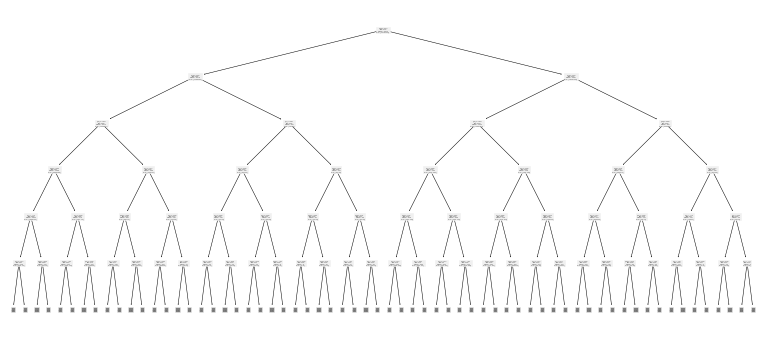

In [ ]:
# visualisasi decision tree dari model Heart Diseases pada 10 level
plt.figure(figsize=(12, 6))
plot_tree(model_default, max_depth=5)
plt.show()

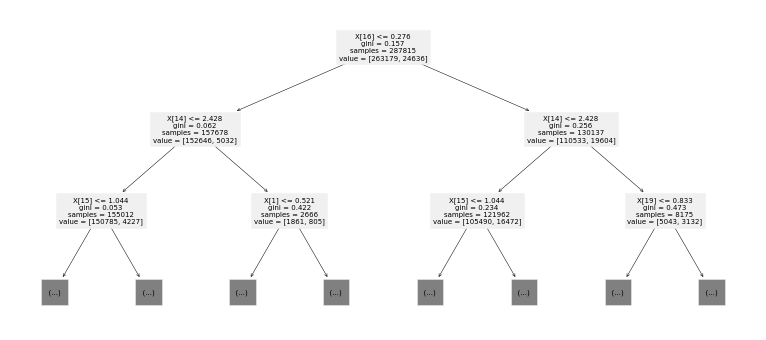

In [ ]:
plt.figure(figsize=(12, 6))
plot_tree(model_default, max_depth=2)
plt.show()

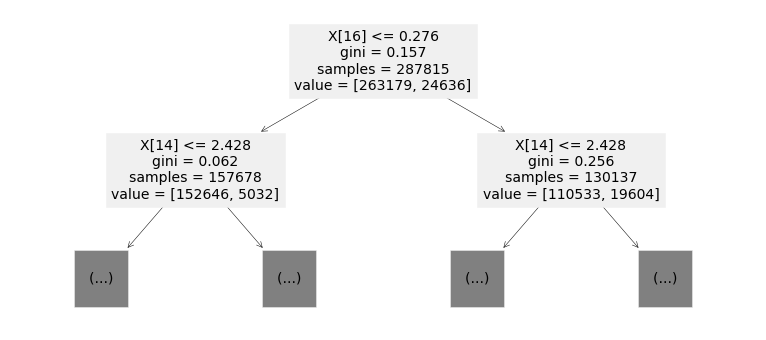

In [ ]:

plt.figure(figsize=(12, 6))
plot_tree(model_default, max_depth=1)
plt.show()

#### 3.2.5 Model Evaluation

              precision    recall  f1-score   support

          No       1.00      1.00      1.00    263179
         Yes       1.00      0.96      0.98     24636

    accuracy                           1.00    287815
   macro avg       1.00      0.98      0.99    287815
weighted avg       1.00      1.00      1.00    287815



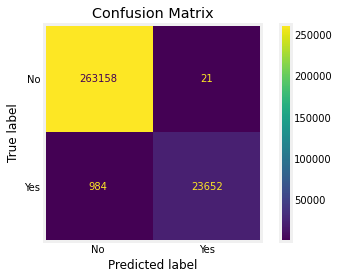

In [ ]:
print(classification_report(y_train, preds_train))

ConfusionMatrixDisplay.from_predictions(y_train, preds_train)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
# menghitung nilai evaluation prediction dari Confussion Matrix
# True label no / Predicted label yes 
263158 / (263158+984)

0.9962747310158929

Insights yang diperoleh dari evaluasi model pada data training adalah:
* semua **evaluation metrics sangat bagus**, mulai dari **accuracy**, **precision**, **recall**, dan **f1-score**
* dari **24,636 data yang berlabel `Yes`**, model gagal memprediksi **984 data** dengan benar (**false negative**). Ini berarti, ada **984** orang yang seharusnya memiliki riwayat penyakit jantung, tapi model mengklasifikan mereka sebagai orang sehat

              precision    recall  f1-score   support

          No       0.93      0.92      0.92     14622
         Yes       0.23      0.25      0.24      1368

    accuracy                           0.86     15990
   macro avg       0.58      0.58      0.58     15990
weighted avg       0.87      0.86      0.87     15990



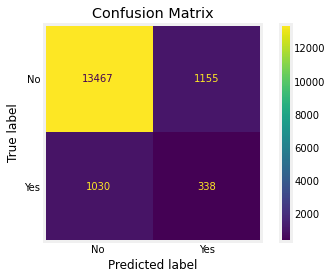

In [ ]:
print(classification_report(y_dev, preds_dev))

ConfusionMatrixDisplay.from_predictions(y_dev, preds_dev)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

> Insights apa yang bisa diambil dari evaluasi model dengan data development di atas?

              precision    recall  f1-score   support

          No       0.93      0.92      0.92     14621
         Yes       0.21      0.23      0.22      1369

    accuracy                           0.86     15990
   macro avg       0.57      0.58      0.57     15990
weighted avg       0.87      0.86      0.86     15990



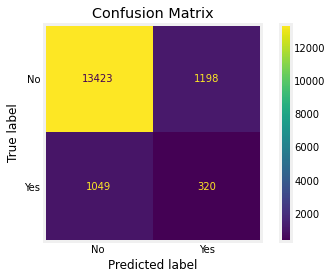

In [ ]:
print(classification_report(y_test, preds_test))

ConfusionMatrixDisplay.from_predictions(y_test, preds_test)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

> Insights apa yang bisa diambil dari evaluasi model dengan data test di atas?

Sebagi penutup, kita bisa melakukan prediksi untuk seluruh data dan menyimpan hasil prediksi menjadi sebuah file CSV seperti berikut.

In [ ]:
X.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [ ]:
ordinal.feature_names_in_.tolist()

['Smoking',
 'AlcoholDrinking',
 'Stroke',
 'DiffWalking',
 'AgeCategory',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

In [ ]:
numerical_features + onehot.get_feature_names_out().tolist() + ordinal.feature_names_in_.tolist()

['BMI',
 'PhysicalHealth',
 'MentalHealth',
 'SleepTime',
 'Race_American Indian/Alaskan Native',
 'Race_Asian',
 'Race_Black',
 'Race_Hispanic',
 'Race_Other',
 'Race_White',
 'Sex_Female',
 'Sex_Male',
 'Smoking',
 'AlcoholDrinking',
 'Stroke',
 'DiffWalking',
 'AgeCategory',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

In [ ]:
column_names = (
    numerical_features
    + onehot.get_feature_names_out().tolist()
    + ordinal.feature_names_in_.tolist()
)
X_processed = pd.concat(
    [
     # numerical features
     X[numerical_features].reset_index(drop=True),
     # one-hot encoded features
     pd.DataFrame(
         onehot.transform(X[nominal_features]).toarray(),
         columns=onehot.get_feature_names_out().tolist()
     ),
     # ordinal encoded features
     pd.DataFrame(
         ordinal.transform(X[ordinal_features]),
         columns=ordinal.feature_names_in_.tolist()
     ),
    ],
    axis=1
)
X_processed_scaled = pd.DataFrame(
    scaler.transform(X_processed),
    columns=X_processed.columns
)

print("Predicting all {} data..".format(X_processed_scaled.shape[0]))
preds_full = model_default.predict(X_processed_scaled)

print("Combine the prediction back to the original data..")
X = X.assign(prediction=preds_full)

print("Overview of the resulting data..")
with pd.option_context("display.max_columns", None):
    display(X.head())

print("Export to CSV..")
X.to_csv("prediction.csv", index=False)

print("Done!")

Predicting all 319795 data..
Combine the prediction back to the original data..
Overview of the resulting data..


,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,prediction
0,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes,Yes
1,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No,No
2,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No,No
3,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes,No
4,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No,No


Export to CSV..
Done!


# 3.2 Modelling w/ Random Forest

In [ ]:
# Import neccesaries packages & modules

import math
from collections import Counter, defaultdict
from functools import partial
from pprint import pprint

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.style.use("fivethirtyeight")

In [ ]:
# import the data
df_heart = pd.read_csv('/content/heart_2020_cleaned.csv')

In [ ]:
df_heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


New -> Correlation Matrix

In [ ]:
fig = px.imshow(df_heart[['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',
                    'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer','BMI', 'PhysicalHealth',
                    'MentalHealth', 'AgeCategory', 'SleepTime']].corr(),color_continuous_scale="Blues")
fig.update_layout(height=800)
fig.show()

In [ ]:
numerical_features = df_heart.select_dtypes(include="number").columns.tolist() # memisahkan kolom numerik
categorical_features = df_heart.select_dtypes(include="object").columns.tolist() # memishakan kolom kategorik

print("Numerical features:")
pprint(numerical_features) # print untuk tipe data yang lebih kompleks (list, tuple, set, dll)
print("Categorical features:")
pprint(categorical_features, compact=True) # agar memastikan categorical_features tidak berubah ketika  dipanggil lagi

Numerical features:
['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
Categorical features:
['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',
 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma',
 'KidneyDisease', 'SkinCancer']


In [ ]:
encode_AgeCategory = {'55-59':57, '80 or older':80, '65-69':67,
                      '75-79':77,'40-44':42,'70-74':72,'60-64':62,
                      '50-54':52,'45-49':47,'18-24':21,'35-39':37,
                      '30-34':32,'25-29':27}
df_heart['AgeCategory'] = df_heart['AgeCategory'].apply(lambda x: encode_AgeCategory[x])
df_heart['AgeCategory'] = df_heart['AgeCategory'].astype('float')

In [ ]:
fig = make_subplots(
    rows=7, cols=2, subplot_titles=("HeartDisease", "Smoking",
                                    "AlcoholDrinking","Stroke",
                                    "DiffWalking", "Sex",
                                    'Race', 'Diabetic',
                                    'PhysicalActivity','GenHealth',
                                    'Asthma', 'KidneyDisease',
                                    'SkinCancer'),
    specs=[[{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}]],
)

colours = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']

fig.add_trace(go.Pie(labels=np.array(df_heart['HeartDisease'].value_counts().index),
                     values=[x for x in df_heart['HeartDisease'].value_counts()], hole=.35,
                     textinfo='label+percent', rotation=-45, marker_colors=colours),
              row=1, col=1)

fig.add_trace(go.Pie(labels=np.array(df_heart['Smoking'].value_counts().index),
                     values=[x for x in df_heart['Smoking'].value_counts()], hole=.35,
                     textinfo='label+percent', marker_colors=colours),
              row=1, col=2)

fig.add_trace(go.Pie(labels=np.array(df_heart['AlcoholDrinking'].value_counts().index),
                     values=[x for x in df_heart['AlcoholDrinking'].value_counts()], hole=.35,
                     textinfo='label+percent', rotation=-45, marker_colors=colours),
              row=2, col=1)

fig.add_trace(go.Pie(labels=np.array(df_heart['Stroke'].value_counts().index),
                     values=[x for x in df_heart['Stroke'].value_counts()], hole=.35,
                     textinfo='label+percent', rotation=-45, marker_colors=colours),
              row=2, col=2)

fig.add_trace(go.Pie(labels=np.array(df_heart['DiffWalking'].value_counts().index),
                     values=[x for x in df_heart['DiffWalking'].value_counts()], hole=.35,
                     textinfo='label+percent', marker_colors=colours),
              row=3, col=1)

fig.add_trace(go.Pie(labels=np.array(df_heart['Sex'].value_counts().index),
                     values=[x for x in df_heart['Sex'].value_counts()], hole=.35,
                     textinfo='label+percent', marker_colors=colours),
              row=3, col=2)

fig.add_trace(go.Pie(labels=np.array(df_heart['Race'].value_counts().index),
                     values=[x for x in df_heart['Race'].value_counts()], hole=.35,
                     textinfo='label+percent', rotation=-45, marker_colors=colours),
              row=4, col=1)

fig.add_trace(go.Pie(labels=np.array(df_heart['PhysicalActivity'].value_counts().index),
                     values=[x for x in df_heart['PhysicalActivity'].value_counts()], hole=.35,
                     textinfo='label+percent', marker_colors=colours),
              row=4, col=2)

fig.add_trace(go.Pie(labels=np.array(df_heart['Diabetic'].value_counts().index),
                     values=[x for x in df_heart['Diabetic'].value_counts()], hole=.35,
                     textinfo='label+percent', rotation=-45, marker_colors=colours),
              row=5, col=1)

fig.add_trace(go.Pie(labels=np.array(df_heart['GenHealth'].value_counts().index),
                     values=[x for x in df_heart['GenHealth'].value_counts()], hole=.35,
                     textinfo='label+percent', marker_colors=colours),
              row=5, col=2)

fig.add_trace(go.Pie(labels=np.array(df_heart['Asthma'].value_counts().index),
                     values=[x for x in df_heart['Asthma'].value_counts()], hole=.35,
                     textinfo='label+percent', rotation=-45, marker_colors=colours),
              row=6, col=1)

fig.add_trace(go.Pie(labels=np.array(df_heart['KidneyDisease'].value_counts().index),
                     values=[x for x in df_heart['KidneyDisease'].value_counts()], hole=.35,
                     textinfo='label+percent', rotation=-45, marker_colors=colours),
              row=6, col=2)

fig.add_trace(go.Pie(labels=np.array(df_heart['SkinCancer'].value_counts().index),
                     values=[x for x in df_heart['SkinCancer'].value_counts()], hole=.35,
                     textinfo='label+percent', rotation=-45, marker_colors=colours),
              row=7, col=1)


fig.update_layout(height=3200, font=dict(size=14), showlegend=False)

fig.show()

In [ ]:
print('Continuous Columns')
df_heart.select_dtypes(include=['float']).describe().T[['min', 'mean', 'max']].style.background_gradient(cmap='Blues')

Continuous Columns


,min,mean,max
BMI,12.020000,28.325399,94.850000
PhysicalHealth,0.000000,3.371710,30.000000
MentalHealth,0.000000,3.898366,30.000000
AgeCategory,21.000000,54.355759,80.000000
SleepTime,1.000000,7.097075,24.000000


In [ ]:
for col in ['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory', 'SleepTime']:
    df_heart[col] = df_heart[col]/df_heart[col].max()

In [ ]:
print('\nCategorical Columns\n')
df_heart.select_dtypes(include=['O']).nunique()


Categorical Columns



HeartDisease        2
Smoking             2
AlcoholDrinking     2
Stroke              2
DiffWalking         2
Sex                 2
Race                6
Diabetic            4
PhysicalActivity    2
GenHealth           5
Asthma              2
KidneyDisease       2
SkinCancer          2
dtype: int64

In [ ]:
# Integer encode columns with 2 unique values
for col in ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']:
    if df_heart[col].dtype == 'O':
        le = LabelEncoder()
        df_heart[col] = le.fit_transform(df_heart[col])
# One-hot encode columns with more than 2 unique values
df_heart = pd.get_dummies(df_heart, columns=['Race', 'Diabetic', 'GenHealth', ], prefix = ['Race', 'Diabetic', 'GenHealth'])

In [ ]:
features = df_heart[['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Race_American Indian/Alaskan Native', 'Race_Asian',
       'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White',
       'Diabetic_No', 'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'GenHealth_Excellent',
       'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good']]

labels = df_heart['HeartDisease']

In [ ]:
# Splitting the dataset- 20% for validation, and the rest 80% for training
train_df = df_heart[:int(len(df_heart)*0.8)]
val_df = df_heart[int(len(df_heart)*0.8):]

In [ ]:
print('\nData in Train:')
print(train_df['HeartDisease'].value_counts())

print('\nData in Val:')
print(val_df['HeartDisease'].value_counts())


Data in Train:
0    233851
1     21985
Name: HeartDisease, dtype: int64

Data in Val:
0    58571
1     5388
Name: HeartDisease, dtype: int64


In [ ]:
x_train = np.array(train_df[['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Race_American Indian/Alaskan Native', 'Race_Asian',
       'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White',
       'Diabetic_No', 'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'GenHealth_Excellent',
       'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good']])
y_train = np.array(train_df['HeartDisease'])

x_val = np.array(val_df[['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Race_American Indian/Alaskan Native', 'Race_Asian',
       'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White',
       'Diabetic_No', 'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'GenHealth_Excellent',
       'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good']])
y_val = np.array(val_df['HeartDisease'])

Modelling -> Random Forest

In [ ]:
# New Module import = Random Forest & K-Neighbors Classifier
from sklearn.linear_model import LinearRegression ,LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC ,SVR
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
# Random Forest Modelling
rf = RandomForestClassifier().fit(x_train, y_train)

y_pred = rf.predict(x_val)

print(classification_report(y_val,y_pred))


              precision    recall  f1-score   support

           0       0.92      0.98      0.95     58571
           1       0.36      0.12      0.18      5388

    accuracy                           0.91     63959
   macro avg       0.64      0.55      0.57     63959
weighted avg       0.88      0.91      0.89     63959



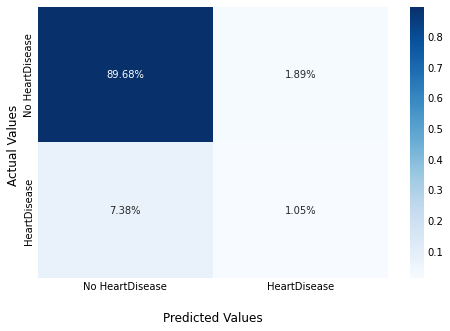

In [ ]:
# Confusion Matrix w/ Random Forest
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['No HeartDisease','HeartDisease'])
ax.yaxis.set_ticklabels(['No HeartDisease','HeartDisease'])

plt.show()

Kaggle Reference:
https://www.kaggle.com/code/mushfirat/heartdisease-eda-prediction/notebook#5-|-Model

# Reference


1.   Grus, Joel. (2015). Data Science from Scratch - First Principles with Python. Sebastopol: O’Reilly Media
2. Kelleher, J. D., Namee, B. M., D'arcy A. (2015). Fundamental of Machine Learning for Predictive data analytics. The MIT Press. 
3. 


